In [5]:
import tensorflow as tf
from tensorflow.python.client import device_lib

#creating extra data from current files  
from datetime import datetime
from tqdm import tqdm

import pandas as pd
import os
from tqdm import tqdm
import numpy as np
from tensorflow import keras
# import bert
# from bert.tokenization.bert_tokenization import FullTokenizer
# from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
# from bert import BertModelLayer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from gensim.models import Word2Vec
# from glove import Corpus, Glove

from tensorflow.keras import initializers 
from tensorflow.keras import regularizers
from tensorflow.keras import constraints

from tensorflow.keras import activations 
from tensorflow.keras import backend as K

# from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
import tensorboard

from transformers import BertTokenizer, BertModel

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Layer,Dropout, LSTM, GRU, Bidirectional, TimeDistributed, Dense
from tensorflow.python.client import device_lib

In [11]:
############################### path check (add path to data)
root_path = ''
list_of_files = []
for root, dir, files in os.walk('../data'):
  root_path = root
  list_of_files = files
  break

In [12]:
print(root_path)
print(files)

./Annotated - CSV
['1288072330011.csv', '1288673034598.csv', '1289452697301.csv', '1289903641088.csv', '1290062946166.csv', '1290154724736_NEG.csv', '1291175003856_NEG.csv', '1312280268805.csv', '1314613428609.csv', '1315463402543.csv', '1324544561749.csv', '1358769139907.csv', '1372830044081.csv', '1380795608703.csv', '1382959468059.csv', '1404099510806.csv', '1404444629445.csv', '1404800940434.csv', '1407404311694.csv', '1407404374671.csv', '1407404413828.csv', '1409133457223.csv', '1427283185104.csv', '1494587603795.csv', '1509190608413.csv', '1522238936458.csv', '1564575450353.csv']


In [13]:
all_dataframes = []
for filename in list_of_files:
  file_path = root_path + '/' + filename
  file_temp = pd.read_csv(file_path)
  all_dataframes.append(file_temp)

In [14]:
all_dataframes[0].head()

,Sentence ID,Label,Sentence
0,F1288072330011_S1,material fact,1. The shares of Genus Commu Trade Limited (he...
1,F1288072330011_S2,procedural fact,SEBI conducted an investigation in respect of ...
2,F1288072330011_S3,material fact,"2. During the investigation period, the scrip ..."
3,F1288072330011_S4,material fact,The price reached the period low (intra day) o...
4,F1288072330011_S5,material fact,During the said period the total traded quanti...


In [15]:
result = pd.DataFrame()
result = result.append(all_dataframes,ignore_index=True)

In [16]:
def tokenize_txt(txt):
    stop_words = set(stopwords.words('english'))
    #only take words or numbers in
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+', gaps=False)
    tokens = tokenizer.tokenize(txt)
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    return tokens

def lemmatization(data):
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in data]
    return ' '.join(lemmatized_text)

In [17]:
print(result.head())

         Sentence ID            Label  \
0  F1288072330011_S1    material fact   
1  F1288072330011_S2  procedural fact   
2  F1288072330011_S3    material fact   
3  F1288072330011_S4    material fact   
4  F1288072330011_S5    material fact   

                                            Sentence  
0  1. The shares of Genus Commu Trade Limited (he...  
1  SEBI conducted an investigation in respect of ...  
2  2. During the investigation period, the scrip ...  
3  The price reached the period low (intra day) o...  
4  During the said period the total traded quanti...  


In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [19]:
result['token'] = result['Sentence'].map(tokenize_txt)
result['lemma'] = result['token'].map(lemmatization)
result['lemma_token'] = result['lemma'].apply(lambda x: tokenizer.tokenize(x))
result['tok_size'] = result['token'].apply(lambda x: len(x))

In [20]:
print(result.count())

Sentence ID    2124
Label          2124
Sentence       2124
token          2124
lemma          2124
lemma_token    2124
tok_size       2124
dtype: int64


In [21]:
train_data = pd.DataFrame(columns= result.columns)
val_data = pd.DataFrame(columns=result.columns)
test_data = pd.DataFrame(columns=result.columns)
for label in result.Label.unique():
  temp_df = result[result['Label'] == label]
  train_index = int(temp_df.shape[0]*0.80)
  train_data = train_data.append(temp_df[:train_index])
  test_data = test_data.append(temp_df[train_index:])

In [14]:
train_data.drop(columns = ['Sentence ID'],axis=1,inplace=True)
test_data.drop(columns = ['Sentence ID'],axis=1, inplace=True)

In [15]:
train_data.head()

,Label,Sentence,token,lemma,lemma_token,tok_size
0,material fact,1. The shares of Genus Commu Trade Limited (he...,"[shares, genus, commu, trade, limited, hereina...",share genus commu trade limited hereinafter re...,"[share, genus, com, ##mu, trade, limited, here...",15
2,material fact,"2. During the investigation period, the scrip ...","[investigation, period, scrip, opened, rs, sep...",investigation period scrip opened r september ...,"[investigation, period, sc, ##rip, opened, r, ...",13
3,material fact,The price reached the period low (intra day) o...,"[price, reached, period, low, intra, day, rs, ...",price reached period low intra day r october f...,"[price, reached, period, low, intra, day, r, o...",12
4,material fact,During the said period the total traded quanti...,"[said, period, total, traded, quantity, shares...",said period total traded quantity share daily ...,"[said, period, total, traded, quantity, share,...",11
5,material fact,"3. For the two months (July 01, 2004 to August...","[two, months, july, august, prior, investigati...",two month july august prior investigation peri...,"[two, month, july, august, prior, investigatio...",16


In [16]:
def get_w2v_avg_embed(Dataframe, df_column, model):
    X = Dataframe[df_column]
    w2v_vecs = np.zeros((len(X), 100))
    i = 0
    for words in X:
        vec = np.zeros(100)
        for word in words:
            if word in model.wv:
                vec += model.wv[word]
            else:
                vec += np.random.rand(100)
        if words:
            w2v_vecs[i] = vec / len(words)
        i += 1
    return w2v_vecs

def get_w2v_sent_embed(Dataframe, df_column, model, max_features):
    X = Dataframe[df_column]
    w2v_vecs = np.zeros((len(X),max_features))
    i = 0
    for words in X:
        vec = np.array([])
        for word in words:
            vec = np.concatenate((vec, model.wv[word]))
        if len(vec) >= max_features:
            vec = vec[:max_features]
        else:       
            vec = np.pad(np.array(vec), (0, max_features-len(vec)))
        w2v_vecs[i] = vec
        i += 1
    return w2v_vecs
    
def get_w2v_weighted_embed(Dataframe, df_column, model, tf_dict):
    X = Dataframe[df_column]
    w2v_vecs = np.zeros((len(X), 100))
    i = 0
    mean = 1
    for words in X:
        vec = np.zeros(100)
        cur_sum = 0
        for word in words:
            # if word != "ttalktomeifyousupportdrumpf" and word != "tatswith":
            if word not in tf_dict:
                value = mean
            else:
                value = tf_dict[word]
            cur_sum+=value
            curr = model.wv[word]
            vec += curr*value
        if cur_sum != 0:
            w2v_vecs[i] = vec / cur_sum
        i += 1
    return w2v_vecs

In [17]:
train_data['Label'].value_counts()

defendant claim           475
material fact             433
procedural fact           256
subjective observation    227
statutory fact            149
issues framed              76
related fact               68
allegation                 65
penalty                    33
violation                  24
Name: Label, dtype: int64

In [18]:
test_data['Label'].value_counts()

defendant claim           119
material fact             109
procedural fact            65
subjective observation     57
statutory fact             38
issues framed              19
related fact               18
allegation                 17
penalty                     9
violation                   7
Name: Label, dtype: int64

In [19]:
classes = train_data.Label.unique().tolist()
classes

['material fact',
 'procedural fact',
 'allegation',
 'defendant claim',
 'issues framed',
 'statutory fact',
 'subjective observation',
 'violation',
 'penalty',
 'related fact']

In [21]:
# w2v_model = Word2Vec(result['lemma'], min_count=1, window=5)
w2v_model = Word2Vec(train_data['lemma_token'], window=5, min_count=1, workers=4)

In [22]:
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape
print(vocab_size, embedding_size)

X = get_w2v_avg_embed(result, 'lemma_token', w2v_model)
# X = get_w2v_sent_embed(result, 'lemma', w2v_model, embedding_size)

y = np.array(pd.get_dummies(result['Label']).values)
y = y.argmax(axis=-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

2651 100


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf_embed(Dataframe, df_column):
    X = Dataframe[df_column]
    tfidf_vectorizer = TfidfVectorizer(max_features=500)
    tfidf_vecs = tfidf_vectorizer.fit_transform(X)
    return tfidf_vecs

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train = tfidf_vectorizer.fit_transform(train_data['lemma'])
X_test = tfidf_vectorizer.transform(test_data['lemma'])

y_train = np.array(pd.get_dummies(train_data['Label']).values)
y_train = y_train.argmax(axis=-1)

y_test = np.array(pd.get_dummies(test_data['Label']).values)
y_test = y_test.argmax(axis=-1)

In [20]:
def get_glove_avg_embed(Dataframe, df_column, model, features):
    X = Dataframe[df_column]
    glove_vecs = np.zeros((len(X), features))
    i = 0
    for words in X:
        vec = np.zeros(features)
        for word in words:
            if word in model.dictionary:
                vec += model.word_vectors[model.dictionary[word]]
            else:
                vec += np.random.rand(features)
        if words:
            glove_vecs[i] = vec / len(words)
        i += 1
    return glove_vecs

In [48]:
# GloVe
train_glove = True
if train_glove:
    corpus = Corpus()
    corpus.fit(train_data['lemma_token'], window=10)
    glove_model = Glove(no_components=500, learning_rate=0.1)
    glove_model.fit(corpus.matrix, epochs=2000, no_threads=4, verbose=True)
    glove_model.add_dictionary(corpus.dictionary)
    glove_model.save('glove.model')
else:
    glove_model = Glove.load('glove.model')

# vocab_size, embedding_size = glove_model.word_vectors
# print(vocab_size, embedding_size)
print(glove_model.word_vectors.shape)

X_train = get_glove_avg_embed(train_data, 'lemma_token', glove_model, 500)
X_test = get_glove_avg_embed(test_data, 'lemma_token', glove_model, 500)

y_train = np.array(pd.get_dummies(train_data['Label']).values)
y_train = y_train.argmax(axis=-1)

y_test = np.array(pd.get_dummies(test_data['Label']).values)
y_test = y_test.argmax(axis=-1)

Performing 2000 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epo

In [21]:
classifier_lst = [LogisticRegression(), RandomForestClassifier(), SVC(), XGBClassifier()]

In [22]:
def train(ClassifierList, X_train, X_test, y_train, y_test):
    for n, Classifier in enumerate(ClassifierList):
        print(f'{n+1} of {len(ClassifierList)} of methods attempting')
        # method={}

        Classifier.fit(X_train, y_train)
        prediction = Classifier.predict(X_test)

        # tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
        # print()
        # print(f"{str(Classifier).split('(')[0]} Confusion Matrix:")
        # print(f"True Negatives: {tn}")
        # print(f"False Positives: {fp}")
        # print(f"False Negatives: {fn}")
        # print(f"True Positives: {tp}")
        # print()

        report = classification_report(y_test, prediction, target_names=classes, output_dict=True)
        class_table = pd.DataFrame(report).transpose()
        display(class_table)
        print()
        print('\n\n', f1_score(y_test, prediction, average='weighted', labels=np.unique(prediction)))

In [23]:
print(train(classifier_lst, X_train, X_test, y_train, y_test))

1 of 4 of methods attempting


D:\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
material fact,0.562500,0.529412,0.545455,17.00000
procedural fact,0.472362,0.789916,0.591195,119.00000
allegation,0.857143,0.631579,0.727273,19.00000
defendant claim,0.736842,0.513761,0.605405,109.00000
issues framed,0.666667,0.222222,0.333333,9.00000
statutory fact,0.815385,0.815385,0.815385,65.00000
subjective observation,0.400000,0.222222,0.285714,18.00000
violation,0.806452,0.657895,0.724638,38.00000
penalty,0.545455,0.421053,0.475248,57.00000
related fact,0.000000,0.000000,0.000000,7.00000





 0.6102006595914992
2 of 4 of methods attempting


,precision,recall,f1-score,support
material fact,0.647059,0.647059,0.647059,17.000000
procedural fact,0.525000,0.705882,0.602151,119.000000
allegation,0.823529,0.736842,0.777778,19.000000
defendant claim,0.666667,0.550459,0.603015,109.000000
issues framed,1.000000,0.444444,0.615385,9.000000
statutory fact,0.875000,0.861538,0.868217,65.000000
subjective observation,0.375000,0.333333,0.352941,18.000000
violation,0.707317,0.763158,0.734177,38.000000
penalty,0.553191,0.456140,0.500000,57.000000
related fact,0.500000,0.142857,0.222222,7.000000





 0.6319697291423307
3 of 4 of methods attempting


D:\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
material fact,0.562500,0.529412,0.545455,17.000000
procedural fact,0.480583,0.831933,0.609231,119.000000
allegation,0.928571,0.684211,0.787879,19.000000
defendant claim,0.694444,0.458716,0.552486,109.000000
issues framed,1.000000,0.444444,0.615385,9.000000
statutory fact,0.898305,0.815385,0.854839,65.000000
subjective observation,0.400000,0.222222,0.285714,18.000000
violation,0.866667,0.684211,0.764706,38.000000
penalty,0.553191,0.456140,0.500000,57.000000
related fact,0.000000,0.000000,0.000000,7.000000


D:\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)





 0.6225422141813451
4 of 4 of methods attempting
[17:41:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,precision,recall,f1-score,support
material fact,0.666667,0.588235,0.625000,17.000000
procedural fact,0.512048,0.714286,0.596491,119.000000
allegation,0.857143,0.631579,0.727273,19.000000
defendant claim,0.689655,0.550459,0.612245,109.000000
issues framed,0.666667,0.444444,0.533333,9.000000
statutory fact,0.809524,0.784615,0.796875,65.000000
subjective observation,0.411765,0.388889,0.400000,18.000000
violation,0.694444,0.657895,0.675676,38.000000
penalty,0.519231,0.473684,0.495413,57.000000
related fact,0.500000,0.142857,0.222222,7.000000





 0.6144693671995779
None


10
10


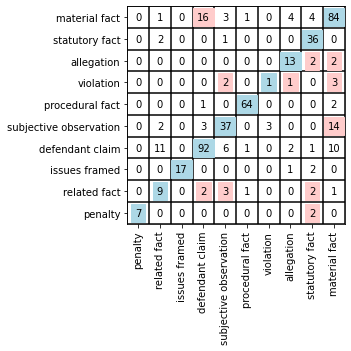

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


height, width = cm.shape
print(height)
print(width)

fig = plt.figure('confusion matrix')
ax = fig.add_subplot(111, aspect='equal')
for x in range(height):
    rowsum = 0
    for y in range(width):
      if x == y:
        ax.annotate(str(cm[width-x-1][height-y-1]), xy=(y, x), ha='center', va='center',backgroundcolor='#ADD8E6')
        rowsum += cm[width-x-1][height-y-1]
      else:
        ax.annotate(str(cm[width-x-1][height-y-1]), xy=(y, x), ha='center', va='center')
        rowsum += cm[width-x-1][height-y-1] 
    #print(f'row {x} sum is {rowsum}')
    for y in range(width):
      if x == y:
        pass
      elif cm[width-x-1][height-y-1] > int(0.1*rowsum):
        ax.annotate(str(cm[width-x-1][height-y-1]), xy=(y, x), ha='center', va='center',backgroundcolor='#ffcccb')
    

offset = .5    
ax.set_xlim(-offset, width - offset)
ax.set_ylim(-offset, height - offset)

ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)



plt.xticks(range(width), classes,rotation=90)
plt.yticks(range(height), classes)
plt.savefig('confusion_matrix.png', format='png')